# Used Car Dataset Price Prediction using Linear Regression

In [1]:
# IMPORT LIBRARIES
# Import Libraries
try:
    # PYSPARK
    from pyspark.sql import SparkSession
    from pyspark import SparkContext
    from pyspark.sql import SQLContext
    from pyspark.sql import DataFrame
    import pyspark.sql.types as tp
    import pyspark.sql.functions as F
    
    #Py Spark ML Libraries
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.regression import LinearRegression
    from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
    from pyspark.ml import Pipeline
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
    
    # OTHER LIBRARIES
    import pandas as pd
    import numpy as np
    import glob
    from functools import reduce
    import seaborn as sns
    import matplotlib.pyplot as plt
    from urllib.request import urlopen
    import datetime
    from pathlib import Path
    
    print('[SUCCESS]')

    #CATCH ERROR IMPORTING A LIBRARY
except ImportError as ie:
    raise ImportError(f'[Error importing]: {ie}')

[SUCCESS]


## Initializing Spark session and cluster for work enviornment

In [2]:

'''
INITIALIZING SPARK SESSION
- NAME IS SET FOR SPARK SESSION WHEN RUNNING ON LOCAL HOST
'''
spark = SparkSession.builder.master('local').config("spark.executor.memory", "1g").config("spark.driver.memory", "2g").appName('UsedCar_Project').getOrCreate()
print('[SUCCESSFULLY RUNNING SPARK SESSION]')


[SUCCESSFULLY RUNNING SPARK SESSION]


# Load data

In [38]:
def load_data():
    '''
    car_prices.csv is uploaded to a google bucket for public use. Since file is too large to push to GitHub for others to use from repo
    this function will load the data from the google bucket.
    
    You can run this function each time and it will not download a new dataset each time since the first time you run it, it will download locally to your directory.
    --- unless you delete it each time
    
    Function will check to make sure file is in the directory
    - if it is, load it to a spark dataframe
    - if it is not, download it, then load it to a spark dataframe
    
    
    
    WARNING: TO USE THIS FUNCTION, YOU HAVE TO BE RUNNING JUPYTER NOTEBOOK ON A LINUX SERVER (USE DOCKER)
    
    NOTES:
    option("header",True).option("inferSchema", True)
    '''
    
    # CHECKS TO SEE IF FILE EXIST
    path = Path('car_prices.csv') 
    
    # IF FILE DOES NOT EXIST
    if not path.is_file():
        !wget https://storage.googleapis.com/iamangelsh-public-datasets/car_prices.csv 
    
    df = spark.read.csv("car_prices.csv", header = True, sep=",", inferSchema = True) # LOAD IN DATA WITH HEADERS
    
    return df


# LOAD THE DATA
df = load_data()

# SHOW DATA
df.show(5)

# SHOW NUMBER OF COLUMNS AND ROWS
print(f'Number of columns: {len(df.columns)} \nNumber of Rows: {df.count()}')
print()
df.printSchema()

+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|year| make|              model|      trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|            saledate|
+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg566472|   ca|        5| 16639.0|white|   black|kia motors americ...|20500|       21500|Tue Dec 16 2014 1...|
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg561319|   ca|        5|  9393.0|white|   beige|kia motors americ...|20800|       21500|Tue Dec 16 2014 1...|
|2014|  BMW|           3 Series|328i SULEV|Sedan|   automatic|wba3c1c51ek116351|   ca|    

## Check for null values in our dataframe

In [30]:
def null_values(df):
    '''
    TAKES IN A DATAFRAME AND RETURNS THE COUNT OF NULL VALUES IN EACH COLUMN
    '''
    return df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])

NULL_VAL_COUNTS = null_values(df)
NULL_VAL_COUNTS.show()

+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65353|  4|    0|    11794|      94|  749|     749|     0|  0|           0|       0|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



### Notes on columns to drop

Drop:
- VIN
- MMR
    - I don't think we need to use MMR since we aren't using it to predict saleprice as this is only an indicator of "WHOLESALE Prices"
- Seller
    - Drop, to much noise in the column that will not add value to our modeling (maybe for EDA)?

Create new columns - an idea?:
- Add a threshold in the condition column
    - Such as above 3.75 =  Good
    - 2 - 3.75 = Medium
    - Anything less < 2 = bad
    
   

**Function to graph our visual selections for better comprehension**

In [36]:
def plot_basic_visuals(df, col_name: str):
    '''
    Parameters:
    - PySpark Dataframe with only 2 columns
    - Column name that we want to plot (as a string)
    
    Uses:
    - Function will select desired column, group by column and count each type
    - Function will convert PySpark Dataframe into a Pandas Dataframe
    - Will then plot x and y 
    '''
    df = df.select([col_name]).groupBy(col_name).count()
    pandas_df = df.toPandas()
    pandas_df.plot(kind='bar', x=pandas_df.columns[0], y=pandas_df.columns[1], colormap='winter_r', figsize=(20,6))
    
    


**Visuals on Columns by count and type**

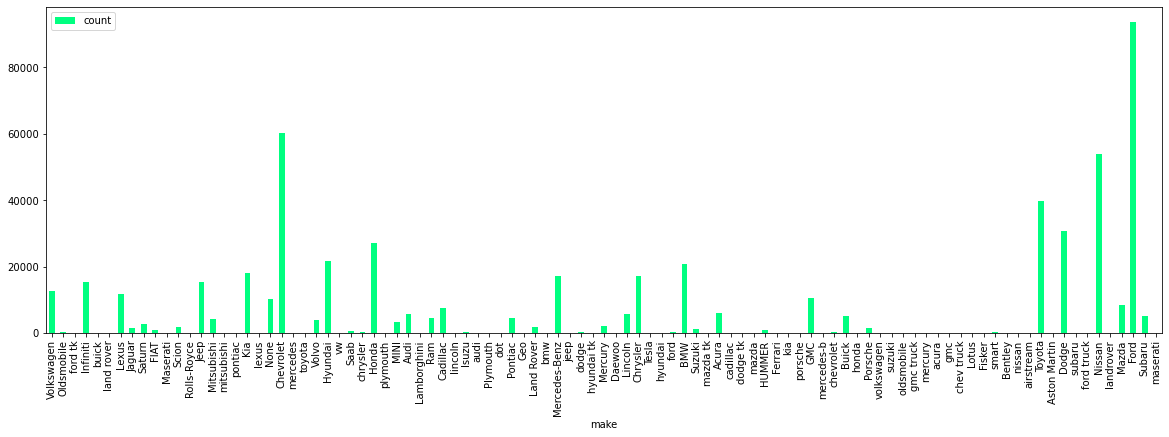

In [20]:
plot_basic_visuals(df, 'make')

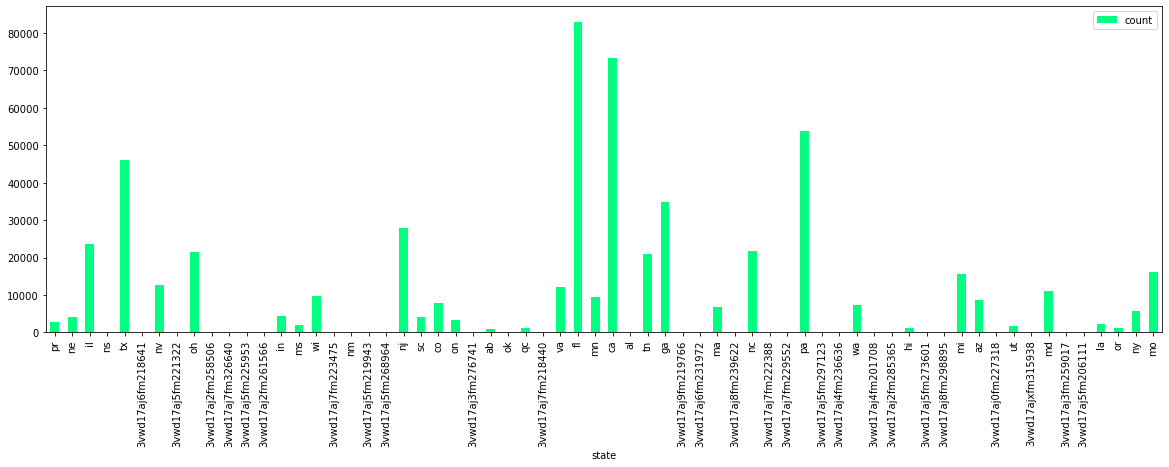

In [37]:
plot_basic_visuals(df, 'state')

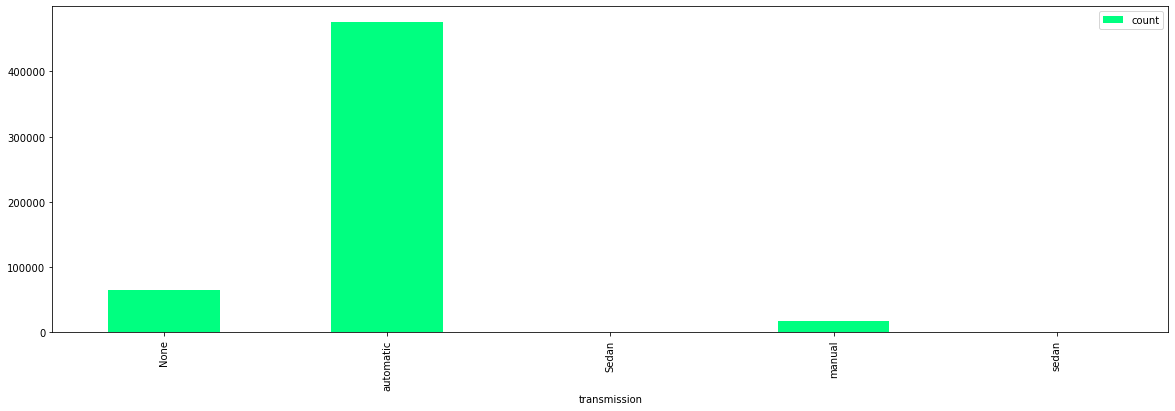

In [25]:
plot_basic_visuals(df, 'transmission')

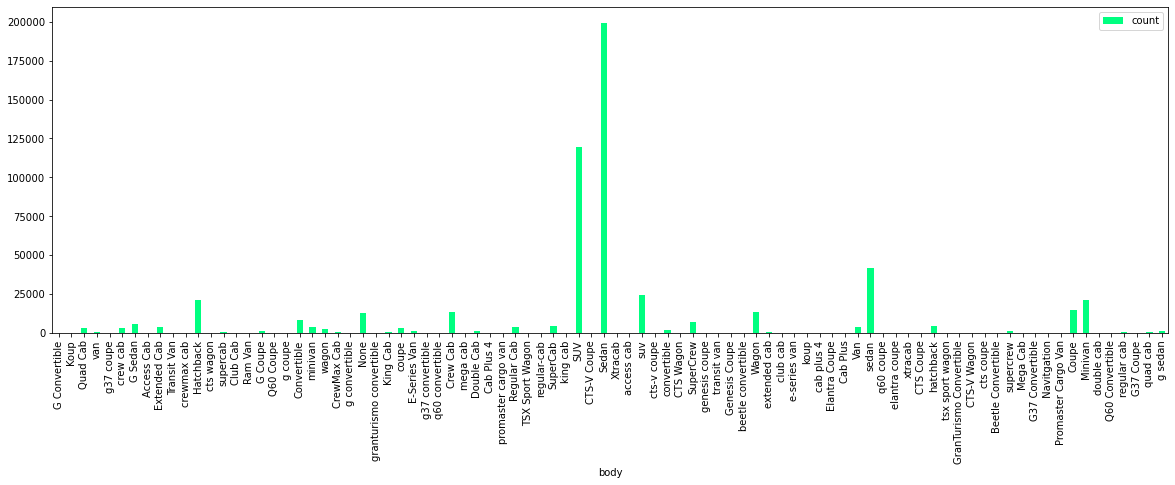

In [26]:
plot_basic_visuals(df, 'body')

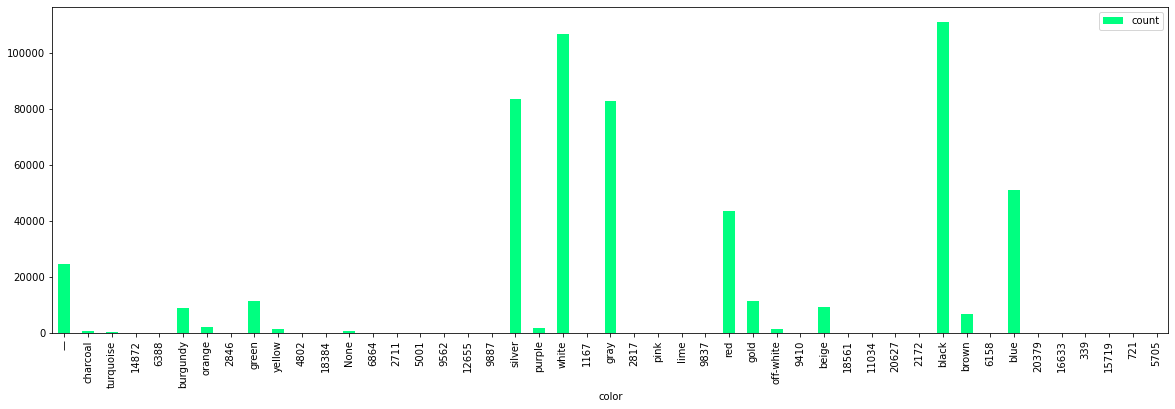

In [27]:
plot_basic_visuals(df, 'color')

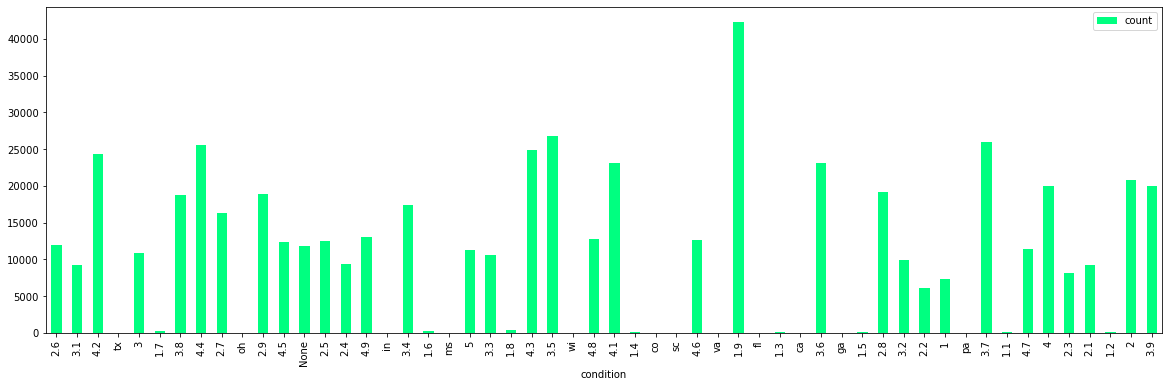

In [28]:
plot_basic_visuals(df, 'condition')